### Step 1. Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso,BayesianRidge
from sklearn.feature_selection import f_regression
from sklearn.svm import SVR

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Step2. Load and Visualize Data

In [4]:
#retrieve data from csv files
root = ''#please replace this with your data path
hp_train = pd.read_csv(root+'train.csv')#Load Training Data
hp_test = pd.read_csv(root+'test.csv')#Load Testing Data

In [5]:
hp_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

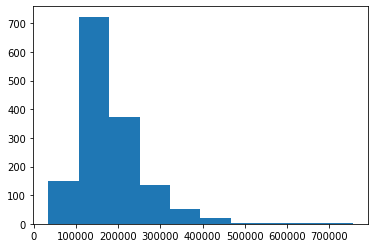

In [6]:
plt.hist(hp_train['SalePrice']) #check the salesprice distribution

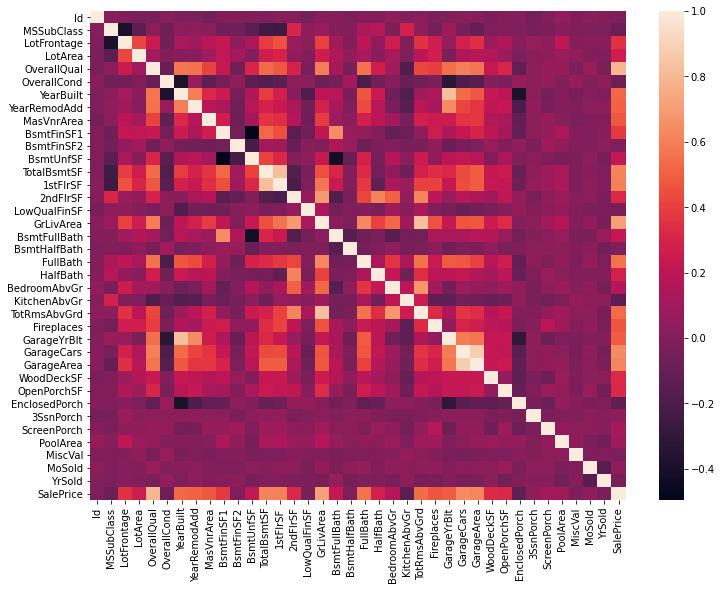

In [7]:
corrmat = hp_train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

### Step3. Preprocessing Data

##### Normalization

In [8]:
numeric_train = np.array(hp_train.select_dtypes(exclude=['object']))[:,1:-1]
prices = np.array(hp_train.select_dtypes(exclude=['object']))[:,-1]
numeric_train_1 = (numeric_train - np.nanmean(numeric_train, axis=0))/np.nanstd(numeric_train, axis=0)

In [9]:
numeric_train_1

array([[ 0.07337496, -0.20803433, -0.20714171, ..., -0.08768781,
        -1.5991111 ,  0.13877749],
       [-0.87256276,  0.40989452, -0.09188637, ..., -0.08768781,
        -0.48911005, -0.61443862],
       [ 0.07337496, -0.08444856,  0.07347998, ..., -0.08768781,
         0.99089135,  0.13877749],
       ...,
       [ 0.30985939, -0.16683907, -0.14781027, ...,  4.95311151,
        -0.48911005,  1.64520971],
       [-0.87256276, -0.08444856, -0.08016039, ..., -0.08768781,
        -0.8591104 ,  1.64520971],
       [-0.87256276,  0.20391824, -0.05811155, ..., -0.08768781,
        -0.1191097 ,  0.13877749]])

##### None Value Handling

In [10]:
numeric_train_no_zero = np.nan_to_num(numeric_train_1,nan=0)#replace null value with 0

##### Encoding

In [11]:
hp_train['LotShape'].head(10) #test the function of get_dummies(), before transformation

0    Reg
1    Reg
2    IR1
3    IR1
4    IR1
5    IR1
6    Reg
7    IR1
8    Reg
9    Reg
Name: LotShape, dtype: object

In [12]:
pd.get_dummies(hp_train['LotShape']).head(10) #after 

,IR1,IR2,IR3,Reg
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,0,0,0,1
7,1,0,0,0
8,0,0,0,1
9,0,0,0,1


In [13]:
# taining encoding needs to be done together with test set in order to predict
all_cat_data =pd.concat((hp_train.iloc[:, 1:-1], hp_test.iloc[:, 1:]))
catgory_data_all = np.array(pd.get_dummies(all_cat_data.select_dtypes(include=['object']), dummy_na=True))

In [14]:
#after encoding, seperate the trainin and testing data
catgory_data_train = catgory_data_all[:1460]
catgory_data_test = catgory_data_all[1460:]

In [15]:
data_train = np.hstack((numeric_train_no_zero,catgory_data_train))

### Step4.Split the training data to train set and validation set

In [32]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_target, val_target = train_test_split(data_train, prices,test_size=0.2)

### Step5.Build Benchmark and Test the performance of Selected Model

#### Benchmark model and performance calculation

In [43]:
regLR =LinearRegression().fit(train_data, train_target)
def LR_predict(val_data):
  return [i if i>0 else 0.0001 for i in regLR.predict(val_data)]#avoid ouput zero or negrive value

pre_out = LR_predict(val_data)

LR_mse = mean_squared_error(np.log(val_target), np.log(pre_out))
print(LR_mse)

11.252879726200055


#### Ridge Regression Model

##### Find the best paramter for Ridge Regression Model

In [34]:
param_grid = {'alpha':[20,10,5 ,1,0.1,0.02,0.01,0.005, 0.001]}
kr = GridSearchCV(Ridge(), param_grid=param_grid)
kr.fit(train_data, train_target)
kr.best_params_

{'alpha': 5}

In [35]:
refRD = Ridge(alpha=10)
refRD.fit(train_data, train_target)
pre_out_RD = refRD.predict(val_data)

RD_mse = mean_squared_error(np.log(val_target), np.log(pre_out_RD))
print(RD_mse)

0.02787323299014488


#### Lasso Regression Model

##### Find the best paramter for Lasso Regression Model

In [36]:
param_grid = {'alpha':[20,10,5 ,1,0.1,0.02,0.01,0.005, 0.001]}
kr = GridSearchCV(Lasso(), param_grid=param_grid)
kr.fit(train_data, train_target)
kr.best_params_

{'alpha': 20}

In [37]:
refLS = Lasso(alpha=20)
refLS.fit(train_data, train_target)
pre_out_LS = refLS.predict(val_data)

LS_mse = mean_squared_error(np.log(val_target), np.log(pre_out_LS))
print(RD_mse)

0.02787323299014488


#### SVM Regression Model

In [38]:
param_grid = {'C':[100,50,30,20,10,1],
             'epsilon':[20,10,1,0.1,0.02,0.01,0.005, 0.001]}
kr = GridSearchCV(SVR(), param_grid=param_grid)
kr.fit(train_data, train_target)
kr.best_params_

{'C': 100, 'epsilon': 0.001}

In [39]:
regSVR = SVR(C=100, epsilon=20)
regSVR.fit(train_data, train_target)
pre_SVR = regSVR.predict(val_data)

SVR_mse = mean_squared_error(np.log(val_target), np.log(pre_SVR))
print(SVR_mse)

0.13192491118544084


#### Bayesian Regression Model

In [40]:
regBY = BayesianRidge()
regBY.fit(train_data, train_target)
pre_BY = regBY.predict(val_data)

BY_mse = mean_squared_error(np.log(val_target), np.log(pre_BY))
print(BY_mse)

0.027709905634908508


#### Plot all prediction in one figure

<Figure size 1080x360 with 0 Axes>

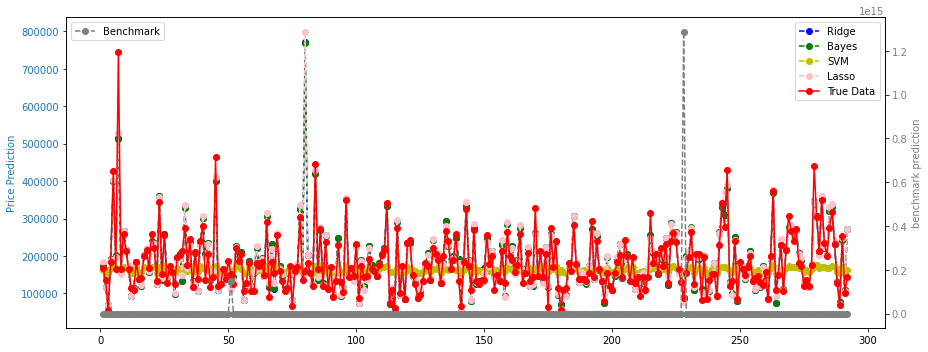

In [41]:
plt.figure(figsize=(15,5))
x_axis = np.arange(1,len(val_target)+1)
fig, ax1 = plt.subplots(figsize = (13,5))

color = 'tab:blue'
ax1.set_ylabel('Price Prediction', color=color)
ax1.plot(x_axis,pre_out_RD,linestyle='--', marker='o', color='b')
ax1.plot(x_axis,pre_BY,linestyle='--', marker='o', color='g')
ax1.plot(x_axis,pre_SVR,linestyle='--', marker='o', color='y')
ax1.plot(x_axis,pre_out_LS,linestyle='--', marker='o', color='pink')
ax1.plot(x_axis,val_target,marker='o',color='r')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['Ridge','Bayes','SVM','Lasso','True Data'])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:grey'
ax2.set_ylabel('benchmark prediction', color=color)  # we already handled the x-label with ax1
ax2.plot(x_axis,pre_out, linestyle='--', marker='o',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(['Benchmark'],loc='upper left')
plt.show()

In [61]:
#Check whether the optimized model is significant improved to benchmark Model
from scipy import stats
 
RD_mse = []
LR_mse = []
for i in range(100):
  sample_index = np.random.choice(len(val_data),50)
  pre_out_RD = regBY.predict(val_data[sample_index]) 
  pre_out =  LR_predict(val_data[sample_index])

  RD_mse.append(mean_squared_error(np.log(val_target[sample_index]), np.log(pre_out_RD)))
  LR_mse.append(mean_squared_error(np.log(val_target[sample_index]), np.log(pre_out)))
#print('RD IS:',RD_mse)
#print('\nLR IS:',LR_mse)
mwu_result = stats.mannwhitneyu(RD_mse, LR_mse)
print('MWU result is: {}'.format(mwu_result))
print('\nCan we reject H0?', 'Yes' if mwu_result.pvalue<0.01 else 'No')

MWU result is: MannwhitneyuResult(statistic=1282.0, pvalue=5.266677471075211e-20)

Can we reject H0? Yes


### Produce Prediction

In [29]:
numeric_test = np.array(hp_test.select_dtypes(exclude=['object']))[:,1:]
numeric_test_1 = (numeric_test - np.nanmean(numeric_test, axis=0))/np.nanstd(numeric_test, axis=0)
numeric_test_no_zero = np.nan_to_num(numeric_test_1,nan=0)
print(numeric_test_no_zero.shape)
#catgory_data_test = np.array(pd.get_dummies(hp_test.select_dtypes(include=['object']), dummy_na=True))
print(catgory_data_test.shape)
data_test = np.hstack((numeric_test_no_zero,catgory_data_test))

(1459, 36)
(1459, 295)


In [30]:
test_predict = regBY.predict(data_test)

In [31]:
data_sample = pd.read_csv(root+'sample_submission.csv')
data_sample['SalePrice'] = test_predict
data_sample.to_csv(root+'sample_submission1.csv', index = False)